In [1]:
from sqlalchemy import create_engine
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.sql.window import Window
from pyspark.sql.functions import to_date
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#First we get the bitcoin data from the database

In [3]:
user = ""
password = ""
host = "mysql"  # this is the Docker service name, not localhost
port = 3306
database = "konfio_coding_challenge"

# SQLAlchemy connection string
connection_str = f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_str)


In [4]:
query = """
SELECT *
FROM crypto_currency_value
WHERE date BETWEEN '2022-01-31' AND '2022-04-01'
"""

df = pd.read_sql(query, engine)
df.head()  # show first few rows


,id_crypto_currency_value,id_crypto,crypto_name,crypto_symbol,date,price,created_on,modified_on
0,31,bitcoin,Bitcoin,btc,2022-01-31,38483.1,2025-04-03 01:59:46,2025-04-03 01:59:46
1,32,bitcoin,Bitcoin,btc,2022-02-01,38743.3,2025-04-03 01:59:46,2025-04-03 01:59:46
2,33,bitcoin,Bitcoin,btc,2022-02-02,36953.0,2025-04-03 01:59:46,2025-04-03 01:59:46
3,34,bitcoin,Bitcoin,btc,2022-02-03,37154.6,2025-04-03 01:59:46,2025-04-03 01:59:46
4,35,bitcoin,Bitcoin,btc,2022-02-04,41500.9,2025-04-03 01:59:46,2025-04-03 01:59:46


In [5]:
spark = SparkSession.builder \
    .appName("CryptoMovingAverage") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/03 01:59:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark_df = spark.createDataFrame(df)


/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [7]:
spark_df = spark_df.withColumn("date", to_date("date"))


In [8]:
window_spec = Window.partitionBy("id_crypto").orderBy("date").rowsBetween(-4, 0)

moving_avg_df = spark_df.withColumn(
    "moving_avg_5_day",
    avg("price").over(window_spec)
)


In [9]:
df_ma = moving_avg_df.orderBy("date").toPandas()


/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` inst

In [10]:
df_ma.head()

,id_crypto_currency_value,id_crypto,crypto_name,crypto_symbol,date,price,created_on,modified_on,moving_avg_5_day
0,31,bitcoin,Bitcoin,btc,2022-01-31,38483.1,2025-04-03 01:59:46,2025-04-03 01:59:46,38483.10
1,32,bitcoin,Bitcoin,btc,2022-02-01,38743.3,2025-04-03 01:59:46,2025-04-03 01:59:46,38613.20
2,33,bitcoin,Bitcoin,btc,2022-02-02,36953.0,2025-04-03 01:59:46,2025-04-03 01:59:46,38059.80
3,34,bitcoin,Bitcoin,btc,2022-02-03,37154.6,2025-04-03 01:59:46,2025-04-03 01:59:46,37833.50
4,35,bitcoin,Bitcoin,btc,2022-02-04,41500.9,2025-04-03 01:59:46,2025-04-03 01:59:46,38566.98


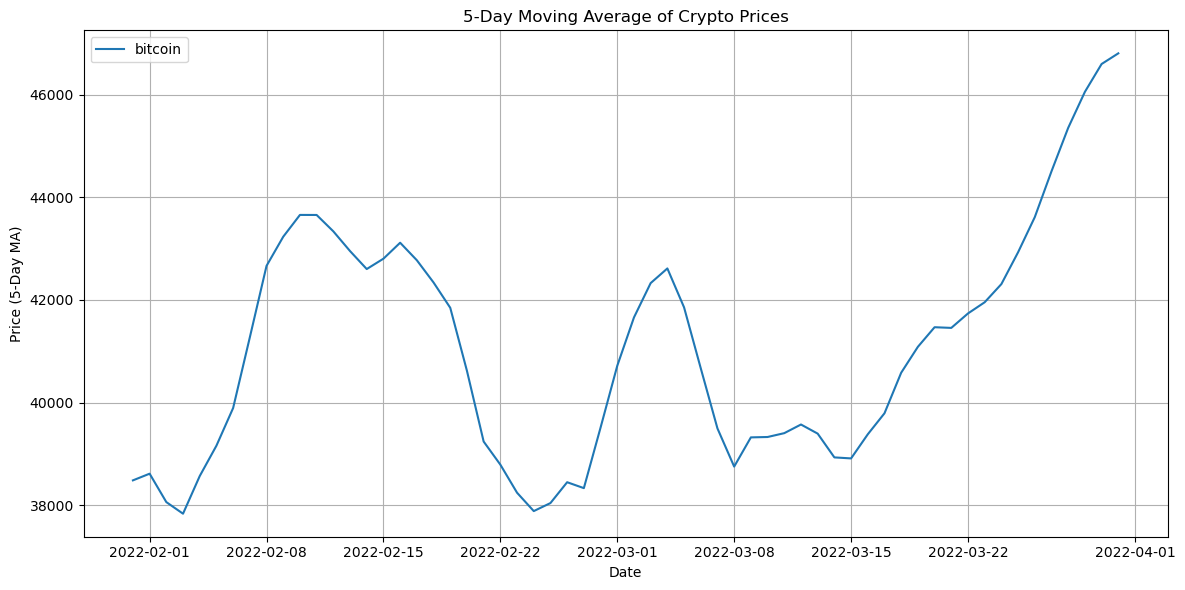

In [11]:
# If you haven't already, convert Spark to Pandas
# (Assuming moving_avg_df is your Spark DataFrame)
#df_ma = moving_avg_df.orderBy("date").toPandas()

# Optional: convert date to datetime just in case
df_ma["date"] = pd.to_datetime(df_ma["date"])

# Plot: one line per coin
plt.figure(figsize=(12, 6))

for coin in df_ma["id_crypto"].unique():
    subset = df_ma[df_ma["id_crypto"] == coin]
    plt.plot(subset["date"], subset["moving_avg_5_day"], label=coin)

plt.title("5-Day Moving Average of Crypto Prices")
plt.xlabel("Date")
plt.ylabel("Price (5-Day MA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
